In [2]:
from matplotlib import colors
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# 1. Data Preparing

In [3]:
#read file
df = pd.read_csv('BasicCompanyDataAsOneFile-2021-11-01.csv')


/opt/anaconda3/envs/Dataviz/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (41,42,43,44,45,46,47,48,49,50,51,52) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
#%% select United Kingdom data
uk_df = df.loc[(df['CountryOfOrigin'] == 'United Kingdom') | (df['CountryOfOrigin'] == 'Great Britain') | (df['CountryOfOrigin'] == 'UNITED KINGDOM')]

#%% 
SIC_df = uk_df[['CompanyName','IncorporationDate','CompanyCategory','RegAddress.PostTown',
                'CompanyStatus','SICCode.SicText_1','SICCode.SicText_2','SICCode.SicText_3','SICCode.SicText_4']]

# --+ 1.Incorporation Year
SIC_df.loc[:,"Year"] = SIC_df['IncorporationDate'].str[6:10].astype(int)

# ---subset
SIC_df = SIC_df.loc[SIC_df['Year'] > 2017]

# %% business industry
SIC_df.loc[:,"Code1"] = SIC_df['SICCode.SicText_1'].str[0:5]
#%%
SIC_df = SIC_df[SIC_df["Code1"].str.contains("No")==False]
#%%
siccode_list = SIC_df['Code1'].to_list()

/opt/anaconda3/envs/Dataviz/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [5]:
# %% append industry information to dataframe
sec_list = []
for i in siccode_list:
    temp = int(i)
    if temp <= 5000:
        sec_list.append('Agriculture, Forestry, and Fishing')
    elif temp <= 9900:
        sec_list.append('Mining and Quarrying')
    elif temp <= 33200:
        sec_list.append('Manufacturing')
    elif temp <= 35300:
        sec_list.append('Electric power generation, transmission and distribution')
    elif temp <= 39000:
        sec_list.append('Water supply, sewerage, waste management and remediation activities')
    elif temp <= 43999:
        sec_list.append('Construction')
    elif temp <= 47990:
        sec_list.append('Wholesale and retail trade; repair of motor vehicles and motorcycles')
    elif temp <= 53202:
        sec_list.append('Transport and storage')        
    elif temp <= 56302:
        sec_list.append('Accommodation and food service activities')
    elif temp <= 63990:
        sec_list.append('Information and communication')
    elif temp <= 66300:
        sec_list.append('Financial and insurance activities')
    elif temp <= 68320:
        sec_list.append('Real estate activities')
    elif temp <= 75000:
        sec_list.append('Professional, scientific and technical activities')
    elif temp <= 82990:
        sec_list.append('Administrative and support service activities')
    elif temp <= 84300:
        sec_list.append('Public administration and defence; compulsory social security')
    elif temp <= 85600:
        sec_list.append('Education')
    elif temp <= 88990:
        sec_list.append('Human health activities')
    elif temp <= 93290:
        sec_list.append('Arts, entertainment and recreation')
    elif temp <= 96090:
        sec_list.append('Other service activities')
    elif temp <= 98200:
        sec_list.append('Activities of households as employers of domestic personnel')
    else:
        sec_list.append('Activities of extraterritorial organisations and bodies')
# %%
SIC_df = SIC_df.assign(Industry = sec_list)

# Plot 1: The Effects of Pandemic on Business Incorporate Pattern

In [6]:
# %% count the industries by year
sec_df = SIC_df.groupby(['Industry', 'Year']).size().reset_index(name='Count_Industry')
#%%
#temp = sec_df.groupby(['Year', 'Industry']).agg({'size': 'sum'})
countsall_df= sec_df.groupby('Year',as_index=False).sum()
#%%
overview_df = pd.merge(sec_df,countsall_df, how ='left', on=['Year'])
#%%
overview_df['Percentage'] = overview_df['Count_Industry_x']/overview_df['Count_Industry_y']
overview_df.style.format({'Percentage': "{:.2%}"})
#%% get london dataframe
london_df = SIC_df.loc[(SIC_df['RegAddress.PostTown'] == 'LONDON')]
#%%
london_df1 = london_df.groupby(['Industry', 'Year']).size().reset_index(name='Count_Industry')
#%%
counts_london_df= london_df1.groupby('Year',as_index=False).sum()

In [7]:
#%% below chart --- time series
# ---+ counts value of SIC code in 2019, 2020
SIC_df['Month'] = pd.DatetimeIndex(SIC_df['IncorporationDate']).month
SIC_df['IncorporationDate'] = SIC_df['Month'].map(str)+ '-' + SIC_df['Year'].map(str)
SIC_df['IncorporationDate'] =  pd.to_datetime(SIC_df['IncorporationDate'], format='%m-%Y')

SIC_df2020 = SIC_df.loc[(SIC_df['Year'] == 2020)][['Year','Code1']]
count_df20= SIC_df2020.groupby(['Code1']).size().reset_index(name = 'count_2020')
SIC_df2021 = SIC_df.loc[(SIC_df['Year'] == 2021)][['Year','Code1']]
count_df21= SIC_df2021.groupby(['Code1']).size().reset_index(name = 'count_2021')
#%%  the most changes
count_df = pd.merge(count_df20,count_df21, how='left', on = 'Code1')
count_df['change'] = count_df['count_2021'] - count_df['count_2020']
sort_df= count_df.sort_values(['change'])
sort_df.dropna()
# get the analysing code1: increase and decrease top 2
# data transformation

Code1  count_2020  count_2021  change
585  70229       25343     20662.0 -4681.0
652  82990       18245     14385.0 -3860.0
722  96090       19961     17121.0 -2840.0
651  82920        2063       242.0 -1821.0
330  41100       14035     12370.0 -1665.0
..     ...         ...         ...     ...
644  82110        1654      3401.0  1747.0
500  56210        4940      7077.0  2137.0
457  47990        7839     10402.0  2563.0
464  49410       14123     19466.0  5343.0
456  47910       30419     35969.0  5550.0

[728 rows x 4 columns]

In [8]:
#%% the lower right data
time_df = SIC_df.loc[(SIC_df['Code1'] == '70229')|(SIC_df['Code1'] == '82990')|(SIC_df['Code1'] == '49410')|(SIC_df['Code1'] == '47910')]
time_df = time_df[['IncorporationDate', 'Code1']]
time_df = time_df.loc[(time_df['IncorporationDate'] >= '2021-1') & (time_df['IncorporationDate'] <= '2021-10')]
time_df.loc[:,'counts'] = np.repeat(1, len(time_df))
monthly_df = time_df.groupby(['Code1', 'IncorporationDate'])['counts'].sum().groupby(level=0).cumsum().reset_index()
monthly1_df = time_df.groupby(['Code1', 'IncorporationDate'])['counts'].sum().reset_index()
#%%
df_70229 = time_df.loc[(time_df['Code1'] == '70229')].groupby(['Code1', 'IncorporationDate'])['counts'].sum().reset_index()
df_82990 = time_df.loc[(time_df['Code1'] == '82990')].groupby(['Code1', 'IncorporationDate'])['counts'].sum().reset_index()
df_49410 = time_df.loc[(time_df['Code1'] == '49410')].groupby(['Code1', 'IncorporationDate'])['counts'].sum().reset_index()
df_47910 = time_df.loc[(time_df['Code1'] == '47910')].groupby(['Code1', 'IncorporationDate'])['counts'].sum().reset_index()


<ipython-input-9-35ca451a7704>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


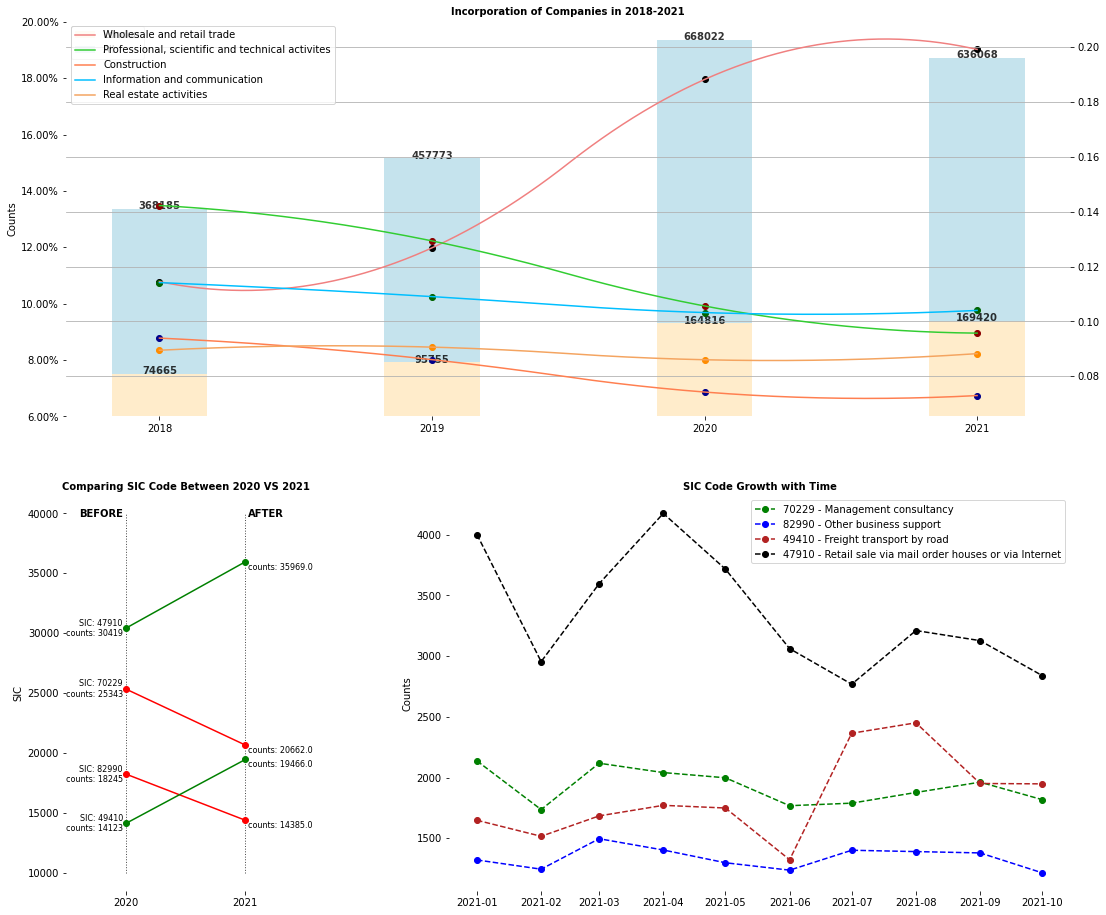

In [9]:
#%% plot data
# (1) some variable might use for plot
x = ['2018','2019','2020','2021']
x_counts = countsall_df['Count_Industry']
london_companies = counts_london_df['Count_Industry']
all_companies = countsall_df['Count_Industry']
width = 0.35 # the width of the bars: can also be len(x) sequence

x_pos = [0,1,2,3]
label = ['Wholesale and retail trade',
         'Professional, scientific and technical activites',
         'Construction',
         'Information and communication',
         'Real estate activities',
         ]

#%%
# (1) preset 
##create figure
fig = plt.figure(figsize=(18, 16))


# (2) bar chart 
##create plot
from matplotlib.gridspec import GridSpec
gs = GridSpec(2,3, wspace = 0.6)
ax = fig.add_subplot(gs[:-1,:])

##create plot
ax.bar(x, london_companies, width, label='London', color = 'moccasin',alpha=0.7)
ax.bar(x, all_companies-london_companies, width, label='All', color = 'lightblue', alpha =0.7, bottom = london_companies)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# (3) line chart: econdary ax
ax2 = ax.twinx()
ax2.scatter(x, overview_df[overview_df['Industry'] == 'Wholesale and retail trade; repair of motor vehicles and motorcycles']['Percentage'], c='black')
param = np.linspace(0, 1, len(x))
spl = make_interp_spline(param, np.c_[x_pos, overview_df[overview_df['Industry'] == 'Wholesale and retail trade; repair of motor vehicles and motorcycles']['Percentage']], k=2)
xnew, y_smooth = spl(np.linspace(0, 1, len(x) * 100)).T
plt.plot(xnew, y_smooth,c= 'lightcoral', label=label[0])

ax2.scatter(x, overview_df[overview_df['Industry'] == 'Professional, scientific and technical activities']['Percentage'], c='darkred')
param = np.linspace(0, 1, len(x))
spl = make_interp_spline(param, np.c_[x_pos, overview_df[overview_df['Industry'] == 'Professional, scientific and technical activities']['Percentage']], k=2)
xnew, y_smooth = spl(np.linspace(0, 1, len(x) * 100)).T
plt.plot(xnew, y_smooth, c= 'limegreen', label=label[1])

ax2.scatter(x,overview_df[overview_df['Industry'] == 'Information and communication']['Percentage'], c='darkblue')
param = np.linspace(0, 1, len(x))
spl = make_interp_spline(param, np.c_[x_pos, overview_df[overview_df['Industry'] == 'Information and communication']['Percentage']], k=2)
xnew, y_smooth = spl(np.linspace(0, 1, len(x) * 100)).T
plt.plot(xnew, y_smooth, c= 'coral', label=label[2])

ax2.scatter(x,overview_df[overview_df['Industry'] == 'Construction']['Percentage'], c='darkgreen')
param = np.linspace(0, 1, len(x))
spl = make_interp_spline(param, np.c_[x_pos, overview_df[overview_df['Industry'] == 'Construction']['Percentage']], k=2)
xnew, y_smooth = spl(np.linspace(0, 1, len(x) * 100)).T
plt.plot(xnew, y_smooth, c= 'deepskyblue', label=label[3])

ax2.scatter(x,overview_df[overview_df['Industry'] == 'Real estate activities']['Percentage'], c='darkorange')
param = np.linspace(0, 1, len(x))
spl = make_interp_spline(param, np.c_[x_pos, overview_df[overview_df['Industry'] == 'Real estate activities']['Percentage']], k=2)
xnew, y_smooth = spl(np.linspace(0, 1, len(x) * 100)).T
plt.plot(xnew, y_smooth, c= 'sandybrown', label=label[4])

# (4) manipulate
vals = ax2.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

## aest
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.0)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.0)

# (5) 
for i, v in enumerate(all_companies):
    ax.text(x_pos[i], v + 5, all_companies[i], ha='center', color='Black', fontweight='bold',alpha=0.8, zorder=2)
for i, v in enumerate(london_companies):
    ax.text(x_pos[i], v + 5, london_companies[i], ha='center', color='Black', fontweight='bold',alpha=0.8, zorder=2)



# decoration

ax.set_ylabel('Counts')
ax.set_title('Incorporation of Companies in 2018-2021',fontdict={'size': 10, 'weight': 700})
ax.legend()
ax2.legend()


plt.grid()

#(6) plot the right lower chart
ax1 = fig.add_subplot(gs[-1, -2:])
ax2 = fig.add_subplot(gs[-1, :-2])

# --+ plot data
ax1.plot_date(df_70229['IncorporationDate'], df_70229['counts'], color='green', label = '70229 - Management consultancy', ls = '--') 
ax1.plot_date(df_82990['IncorporationDate'], df_82990['counts'], color='blue', label = '82990 - Other business support', ls = '--') 
ax1.plot_date(df_49410['IncorporationDate'], df_49410['counts'], color='firebrick', label = '49410 - Freight transport by road',ls = '--') 
ax1.plot_date(df_47910['IncorporationDate'], df_47910['counts'], color='black', label = '47910 - Retail sale via mail order houses or via Internet',ls = '--')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.grid(False)
ax1.set_ylabel('Counts')
ax1.set_title('SIC Code Growth with Time',fontdict={'size': 10, 'weight': 700})
ax1.legend()

## aest
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)


# plot the left lower chart
sort1_df = sort_df.loc[(sort_df['Code1'] == '70229')|(sort_df['Code1'] == '82990')|(sort_df['Code1'] == '49410')|(sort_df['Code1'] == '47910')]
sort1_df = sort1_df.assign(Code_name = ['Management consultancy activities other than financial management', 'Other business support service activities n.e.c.', '	Freight transport by road', 'Retail sale via mail order houses or via Internet'])

#draw line
import matplotlib.lines as mlines
# custom function that defines a new line
def newline(_p_1, _p_2, color='black'):
    _ax = plt.gca()
    _l = mlines.Line2D([_p_1[0], _p_2[0]], [_p_1[1], _p_2[1]],
                       color='red' if _p_1[1] - _p_2[1] > 0 else 'green',
                       marker='o', markersize=6)
    _ax.add_line(_l)
    return _l

ax2.vlines(x=1, ymin=10000, ymax=40000,
          color='black', alpha=0.7,
          linewidth=1, linestyles=':')
ax2.vlines(x=3, ymin=10000, ymax=40000,
          color='black', alpha=0.7,
          linewidth=1, linestyles=':')

# add points
ax2.scatter(y=sort1_df['count_2020'], x=np.repeat(1, sort1_df.shape[0]),
           s=7, color='black', alpha=0.7)
ax2.scatter(y=sort1_df['count_2021'], x=np.repeat(3, sort1_df.shape[0]),
           s=7, color='black', alpha=0.7)

# line segments and annotations
for p1, p2, c in zip(sort1_df['count_2020'], sort1_df['count_2021'], sort1_df['Code1']):
    newline([1, p1], [3, p2])
    ax2.text(1 - 0.05, p1, 'SIC: ' + c + '\n' + 'counts: ' + str(p1),
            horizontalalignment='right',
            verticalalignment='center',
            fontdict={'size': 8})
    ax2.text(3 + 0.05, p2, '\n' + 'counts: ' + str(p2),
            horizontalalignment='left',
            verticalalignment='center',
            fontdict={'size': 8})
        
# 'before' and 'after' annotations
ax2.text(1 - 0.05, 40000, 'BEFORE',
        horizontalalignment='right',
        verticalalignment='center',
        fontdict={'size': 10, 'weight': 700})
ax2.text(3 + 0.05, 40000, 'AFTER',
        horizontalalignment='left',
        verticalalignment='center',
        fontdict={'size': 10, 'weight': 700})

# decoration
ax2.set_title("Comparing SIC Code Between 2020 VS 2021",
             fontdict={'size': 10, 'weight': 700})
ax2.set(xlim=(0, 4), ylabel='SIC')
ax2.set_xticks([1, 3])
ax2.set_xticklabels(["2020", "2021"])
#plt.yticks(np.arange(500, 13000, 2000), fontsize=12)


# lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.0)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.0)

plt.show()

# Plot 2: Difference Among Industries in Active / Non-Active Ratio in 2019 vs 2020

In [10]:
SIC_df.loc[:,'CompanyStatus'] = [1 if x == 'Active' else 0 for x in SIC_df.loc[:,'CompanyStatus']]

#%%
SIC_df.loc[:,'divers'] = SIC_df.iloc[:,6:10].count(axis = 1)
#%%
SIC_df = SIC_df[SIC_df['divers'] == 1]

#%% Plot2  Data preparing
status_df = SIC_df[['CompanyStatus','Industry','Year']]
status_df = status_df.loc[(status_df['Year'] == 2019)|(status_df['Year'] == 2020)]
# %%
all_df= status_df.groupby(['Industry', 'Year']).size().reset_index(name='All')
# %%
active_df = status_df.groupby(['Industry', 'Year','CompanyStatus']).size().reset_index(name='active')
active_df = active_df[active_df['CompanyStatus'] == 1]

In [11]:
#%%calculate overall data
year_list = [2019, 2020]
active_df.index = range(len(active_df.index))
for i in year_list:
    active_df.loc[len(active_df)] = ['Overall', i, 1, int(active_df[active_df['Year']== i][['active']].sum())]
    all_df.loc[len(all_df)] = ['Overall', i, int(all_df[all_df['Year'] == i][['All']].sum())]

#%%
active_list =active_df['active'].to_list()
all_df['active'] = active_list
# %%
all_df['ratio'] = all_df['active']/(all_df['All'] - all_df['active'])
#%%
df_19 = all_df[all_df['Year'] == 2019][['Industry','ratio']]
df_20 = all_df[all_df['Year'] == 2020][['Industry','ratio']]
ratio_df = df_19.merge(df_20, on = 'Industry', how = 'left')
ratio_df['gap'] = ratio_df['ratio_y'] - ratio_df['ratio_x']

In [12]:
# %% plot data 
from bokeh.plotting import figure, show, output_file,save
from bokeh.io import curdoc #dark theme
from bokeh.models import (HoverTool, ColorBar, Label, NormalHead, Arrow, SingleIntervalTicker)
from bokeh.palettes import RdYlBu #colorbar https://docs.bokeh.org/en/latest/docs/reference/palettes.html#brewer-palettes
from bokeh.transform import linear_cmap 


Industry_Abb = ['Accommodation', 'Extraterritorial', 'Households', 'Administrative',
                'Agriculture', 'Arts', 'Construction', 'Education', 'Electric power',
                'Financial', 'Human Health', 'Information', 'Manufacturing', 'Mining', 
                'Other', 'Professional', 'Public Administration', 'Real Estate',
                'Transport', 'Water Supply', 'Wholesale', 'Overall']

ratio_df = ratio_df.assign(Industry_Abb = Industry_Abb)

curdoc().theme = 'dark_minimal' # Dark theme

p = figure(width = 1280, height = 720, outline_line_color = None, title = "Difference Among Industries in 2019 vs 2020", y_range = ratio_df['Industry_Abb'])

# Color setting
mapper = linear_cmap(field_name = 'gap', palette = RdYlBu[11], low = min(ratio_df['gap']), high = max(ratio_df['gap']))

# Plotting data
# Gaps line between two years
hover_glyph = p.segment(x0 = 'ratio_x', y0 = 'Industry_Abb', x1 = 'ratio_y', y1 = 'Industry_Abb', line_color = mapper, line_width = 3, line_dash = 'dashed', source = ratio_df)
# 2019 Points
p.circle(ratio_df['ratio_x'], ratio_df['Industry_Abb'], size = 15, fill_color = "lightblue", line_color = "white", line_width = 2, legend_label = '2019')
# 2020 Points
p.circle(ratio_df['ratio_y'], ratio_df['Industry_Abb'], size = 12, fill_color = 'darkblue', line_color ='white', line_width = 2, legend_label = '2020')

# Overall Industry label
arrow = Arrow(x_start = 11.2, x_end = 14.5, y_start = 21.5, y_end = 21.5, line_width = 2, line_color = 'white', start = NormalHead(fill_color = "white", size = 10), end = None)
overall_label = Label(x = 15.3, x_offset = 5, y = 21.3, text = "Overall ratio\n2019 to 2020", text_align = "center", text_baseline = "middle", text_color = 'white', text_font_size = "13px", text_font_style = "bold")
p.add_layout(arrow)
p.add_layout(overall_label)

# Lagned setting
p.legend.title = "Year"
p.legend.title_text_color = "white"

# change appearance of legend text
p.legend.label_text_font = "times"
p.legend.label_text_font_style = "italic"
p.legend.label_text_color = "white"

# change border and background of legend
p.legend.border_line_width = 1
p.legend.border_line_alpha = 0.8

# Label setting
p.xaxis.axis_label = 'Active / Non-Active Ratio'
p.yaxis.axis_label = 'Industry'
text_font_style = 'bold'
p.xaxis.ticker = SingleIntervalTicker(interval=4, num_minor_ticks=0)
p.xgrid.grid_line_dash = "dashed"
p.ygrid.grid_line_color = None

# Colorbar
color_bar = ColorBar(color_mapper = mapper['transform'], width = 8)
color_bar_label = Label(text = 'Difference', angle = 270, angle_units = 'deg', text_color = 'white', text_font_size = '18px', y = 360, x_units = 'screen', y_units = 'screen')
p.add_layout(color_bar, 'right')
p.add_layout(color_bar_label, 'right')

# Tooltips pre-processing
list1 = []
list2 = []
for i in ratio_df['gap']:
    if i >0:
        list1.append('&#9650')
        list2.append('#008000')
    else:
        list1.append('&#9660')
        list2.append('#FF0000')
        
ratio_df = ratio_df.assign(Status = list1)
ratio_df = ratio_df.assign(Color = list2)

# Interactive information
tooltips = """
        <div>
            <span style="font-size: 13px; font-weight: bold;">@Industry</span>&nbsp;
        </div>
        <div>
            <span style="font-size: 17px; font-weight: bold; color: @Color;"> @gap{0.00} </span>&nbsp;
            <span style="font-size: 17px; color: @Color;"> @Status </span>
        </div>
        <div style="font-size: 9px; color: #666;">2019:  (@{ratio_x}{0.00})  &nbsp &#9654 &nbsp 2020:  (@{ratio_y}{0.00}) </div>
        """

# Interactive setting
p.add_tools(HoverTool(tooltips = tooltips, renderers = [hover_glyph]))
p.legend.click_policy = 'mute'

output_file('plot.html', mode='inline')
save(p)
show(p)

# Plot 3: The Diversification of Active Private Limited Company

In [13]:
# %% Plot 3
# read 2020 location json file
import json
with open("2020location.json","r") as pipe:
    coords20 = json.load(pipe)

In [14]:
import plotly.express as px
# get the data of the incorporation date in 2018 in London
geo_df20 = london_df[(london_df['RegAddress.PostTown'] == 'LONDON') & (london_df['Year'] ==2020)]
geo_df20.loc[:,'Diversity'] = geo_df20.iloc[:,5:8].count(axis = 1)
geo_df20 = geo_df20[geo_df20["CompanyCategory"].str.contains("Private Limited Company")==True]
geo_df20.loc[:,'CompanyStatus'] = [1 if x == 'Active' else 0 for x in geo_df20.loc[:,'CompanyStatus']]
# %%
loca_df20 = pd.DataFrame(coords20).T
loca_df20 = loca_df20.reset_index()
loca_df20.rename(columns={'index': "CompanyName"}, inplace=True)
#%%
geo_merge20 = pd.merge(geo_df20,loca_df20, how = "left", on = 'CompanyName')

#%% color="Diveristy", size="Company`status" private limited company 2020
geo_merge20["CompanyCategory"] = geo_merge20["CompanyCategory"].astype(str)
geo_merge20["Diversity"] = geo_merge20["Diversity"].astype(str)
fig = px.scatter_mapbox(geo_merge20, lat ="Lat", lon="Long", color="Diversity", size="CompanyStatus", mapbox_style='open-street-map',
                        color_continuous_scale=px.colors.diverging.Picnic, size_max=5, zoom=10)
fig.update_layout(width=1100, height=500)
fig.write_html("geo.html")
fig.show()

/opt/anaconda3/envs/Dataviz/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
